Andreev spectrum of nanostructure-based junction
syst1: TI system without TRS

# import Kwant

In [1]:
import kwant
print(kwant.version.version)

import matplotlib

import matplotlib.pyplot as plt
#plt.style.use('genstyle')

import time

import pandas as pd

import scipy.sparse.linalg as sla

import numpy as np
import kwant
import kwant.continuum
import peierls as peierls

import adaptive
import holoviews as hv
from holoviews import opts
adaptive.notebook_extension()
from concurrent.futures import ProcessPoolExecutor
from operator import itemgetter

import  sympy
from sympy.physics.matrices import msigma, Matrix
from sympy import eye
from sympy.physics.quantum import TensorProduct

from sympy.utilities.exceptions import SymPyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=SymPyDeprecationWarning)

C:\MARTIN\Anaconda\lib\site-packages\kwant\solvers\default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


1.4.2


In [2]:
pd.options.display.float_format = "{:,.2f}".format

# System creation

In [3]:
import numpy as np

# shape of system
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

# shape of leads
def get_shape_lead_0(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def get_shape_lead_1(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([L, 0, 0])

L_x = 100
W_y = 100
H_z = 100

## 3DTI hamiltonian

In [4]:
import kwant.continuum


norbs = 8 # 8 orbitals (2 for particle-hole x 2 for spin up-down x 2 for orbitals A/B)
ham_TI = ("- mu_bulk * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0) + "
          "S_mag * S_imp(site) * kron(sigma_z, sigma_0, sigma_0)")

ham_TI_lead1 = ("- mu_lead1 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0)")

ham_TI_lead2 = ("- mu_lead2 * kron(sigma_z, sigma_0, sigma_0) + "
          "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
          "{M} * kron(sigma_z, sigma_0, sigma_z) - "
          "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
          "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
          "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
          "m_z * kron(sigma_z, sigma_z, sigma_0)")


epsilon = "(C_0 - C_perp * (k_x**2 + k_y**2) - C_z * k_z**2)"
M = "(M_0 - M_perp * (k_x**2 + k_y**2) - M_z * k_z**2)"

ham_TI = ham_TI.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)


ham_TI_lead1 = ham_TI_lead1.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr_lead1, coords = kwant.continuum.discretize_symbolic(ham_TI_lead1)

ham_TI_lead2 = ham_TI_lead2.format(epsilon=epsilon, M=M, C_0="C_0")
ham_discr_lead2, coords = kwant.continuum.discretize_symbolic(ham_TI_lead2)


signs = [-1, -1, -1, -1, 1, 1, 1, 1]
vector_potential='[-B_z * y, -B_x * z, -B_y * x]'
ham_discr = peierls.apply(ham_discr, coords, A=vector_potential, signs=signs)
ham_discr_lead1 = peierls.apply(ham_discr_lead1, coords, A=vector_potential, signs=signs)
ham_discr_lead2 = peierls.apply(ham_discr_lead2, coords, A=vector_potential, signs=signs)

In [5]:
a = 10
ti_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
ti_lead_0 = kwant.continuum.build_discretized(ham_discr_lead1, coords, grid=a)
ti_lead_1 = kwant.continuum.build_discretized(ham_discr_lead2, coords, grid=a)

In [6]:
syst1 = kwant.Builder()
_ = syst1.fill(ti_syst, *get_shape(L_x, W_y, H_z))

lat = kwant.lattice.cubic(a, norbs=norbs)

In [7]:
sigma_0 = np.identity(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
conservation_law = -np.kron(sigma_z, np.kron(sigma_0, sigma_0))
particle_hole = np.kron(sigma_x, np.kron(sigma_0, sigma_0))
sigma_TR = np.array([[0, -1], [1, 0]])
# i*sigma_y
time_reversal = np.kron(sigma_z, np.kron(sigma_TR, sigma_0))

nleads = 2

lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole
                      )
lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0)),
                       conservation_law=conservation_law,
                       particle_hole=particle_hole
                      )

lead_0.fill(ti_lead_0, *get_shape_lead_0(L_x, W_y, H_z))
lead_1.fill(ti_lead_1, *get_shape_lead_1(L_x, W_y, H_z))

syst1.attach_lead(lead_0)
syst1.attach_lead(lead_1)

[]

In [8]:
systf1 = syst1.finalized()

## Define Disorder

In [9]:
# Define a random number (following gaussian distribution) table for disorder
disorder_3D = np.array([[[kwant.digest.gauss('('+str(ind_x)+ ',' +str(ind_y) + ',' +str(ind_z)+')')
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_x = np.array([[[kwant.digest.gauss(str(ind_x))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_y = np.array([[[kwant.digest.gauss(str(ind_y))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

disorder_z = np.array([[[kwant.digest.gauss(str(ind_z))
                       for ind_z in range(H_z//a+1)]
                      for ind_x in range(L_x//a+1)]
                     for ind_y in range(W_y//a+1)])

def get_S_imp_3D():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_3D[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_x():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_x[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_y():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_y[ind_y, ind_x, ind_z]
    return S_imp

def get_S_imp_z():
    def S_imp(site):
        ind_x = int(site.pos[0]/a)
        ind_y = int(site.pos[1]/a)
        ind_z = int(site.pos[2]/a)
        return disorder_z[ind_y, ind_x, ind_z]
    return S_imp

## Params dict

In [10]:
#params_toy = dict(C_0=0.0,
#                  C_2=3.0,
#                  mu=0.012
#                 )


params_toy = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0205,
                  mu_lead1=0.0205,
                  mu_lead2=0.021,
                  S_imp = get_S_imp_x(),
                  S_mag = 0.000
                 )

params_toy_sim = dict(C_0=0.0,
                  C_2=3.0,
                  mu=0.0,
                 )

#params_TI = dict(A_perp=3.0,
#                 A_z=3.0,
#                 M_0=0.3,
#                 M_perp=15.0,
#                 M_z=15.0,
#                 C_0=0.0,
#                 C_perp=0.0,
#                 C_z=0.0,
#                 m_z=0.0,
#                 mu=0.1
#                )

params_TI = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu_bulk=0.0200627,
                 mu_lead1=0.0200627,
                 mu_lead2=0.0200627,
                 S_imp = get_S_imp_x(),
                 S_mag = 0.0,
                 B_x = 0.5/(W_y*H_z),
                 B_y = 0,
                 B_z = 0,
                 phi_0=1.0,
                 exp=np.exp,
                 a = 10
                 )

params_TI_sim = dict(A_perp=3.0,
                 A_z=3.0,
                 M_0=0.3,
                 M_perp=15.0,
                 M_z=15.0,
                 C_0=0.0,
                 C_perp=0.0,
                 C_z=0.0,
                 m_z=0.0,
                 mu=0
                )

# Andreev spectrum

## Find Bound States (helper functions)

In [11]:
def energy_operator_mask(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    #print(smat.submatrix(0, 0))
    #print(smat.submatrix(1, 1))
    size_L = smat.submatrix((0, 0), (0, 0)).shape[0]
    size_R = smat.submatrix((1, 0), (1, 0)).shape[0]
    mask_e = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    mask_h = np.zeros((2*size_L+2*size_R, 2*size_L+2*size_R), dtype=bool)
    

    mask_e[:size_L, :size_L] = True
    mask_h[size_L:2*size_L, size_L:2*size_L] = True
    mask_e[:size_L, 2*size_L:2*size_L+size_R] = True
    mask_e[2*size_L:2*size_L+size_R,:size_L] = True
    mask_h[size_L:2*size_L, 2*size_L+size_R:2*size_L+2*size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,size_L:2*size_L] = True
    mask_e[2*size_L:2*size_L+size_R,2*size_L:2*size_L+size_R] = True
    mask_h[2*size_L+size_R:2*size_L+2*size_R,2*size_L+size_R:2*size_L+2*size_R] = True
    

    smat_e = smat.data[mask_e].reshape((size_L+size_R,size_L+size_R))
    smat_h = smat.data[mask_h].reshape((size_L+size_R,size_L+size_R))
    #smat_h = reverse(smat_h)

    
    smat_h_copy = np.array(list(smat_h))
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1
        
    
## Not sure this is right
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) - 0.25 * (smat_prod + smat_prod.T.conj())]

def energy_operator_block(syst, p, ph_sym=False, phases=np.zeros(nleads)):
    """Returns the operator of Eq. (9) of paper.
    
    Parameters:
    -----------
    syst : kwant.builder.InfiniteSystem object
        The finalized system.
    p : types.SimpleNamespace object
        A simple container that is used to store Hamiltonian parameters.
    
    Returns:
    --------
    operator : numpy array
        Operator in Eq. (9)."""
    smat = kwant.smatrix(syst, params=p)
    size_L = int(smat.num_propagating(0)/2)
    size_R = int(smat.num_propagating(1)/2)
        
    smat_e = np.block([[smat.submatrix((0,0),(0,0)), smat.submatrix((0,0),(1,0))],
         [smat.submatrix((1,0),(0,0)), smat.submatrix((1,0),(1,0))]])
    smat_h = np.block([[smat.submatrix((0,1),(0,1)), smat.submatrix((0,1),(1,1))],
         [smat.submatrix((1,1),(0,1)), smat.submatrix((1,1),(1,1))]])
    
    smat_h_copy = np.array(list(smat_h))
    


    
    
    i = 0
    for a in smat_h:
        j = 0
        for b in smat_h[0]:
            if i < size_L:
                new_i = size_L - 1 - i
            else:
                new_i = 2*size_L + size_R - 1 - i
            if j < size_L: 
                new_j = size_L - 1 - j
            else:
                new_j = 2*size_L + size_R - 1 - j
            smat_h[new_i][new_j] = smat_h_copy[i][j]
            j+=1
        i+=1

    
## Not sure this is right
    mat_phase_1 = np.identity(size_L)*np.exp(1j*phases[0])
    mat_phase_2 = np.identity(size_R)*np.exp(1j*phases[1])
    mat_phase = np.block([
        [mat_phase_1, np.zeros((size_L, size_R))],
        [np.zeros((size_R, size_L)), mat_phase_2]
    ])

    
    if ph_sym == False:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_h.T.conj() @ mat_phase.conj()
        #print(smat_prod)
    else:
        smat_prod = smat_e.T.conj() @ mat_phase @ smat_e.T @ mat_phase.conj()
        #print(smat_prod)
    return [smat_e, smat_h, 0.5 * np.eye(smat_prod.shape[0]) - 0.25 * (smat_prod + smat_prod.T.conj())]


def e_squared_over_delta(syst, p, ph_sym=False, phases=np.zeros(nleads), method='block'):
    if method == 'mask':
        operator = energy_operator_mask(syst, p, ph_sym, phases)
    elif method == 'block':
        operator = energy_operator_block(syst, p, ph_sym, phases)
    return np.linalg.eigvalsh(operator[2])

def energies_over_delta(syst, p, ph_sym=False, phases=np.zeros(nleads), method='block'):
    """Same as energy_operator(), but returns the 
    square-root of the eigenvalues"""
    if method == 'mask':
        operator = energy_operator_mask(syst, p, ph_sym, phases)
    elif method == 'block':
        operator = energy_operator_block(syst, p, ph_sym, phases)
    return np.sqrt(np.linalg.eigvalsh(operator[2]))

def plot_ABS_spectrum(syst, p, phases, n=3, ph_sym=False, method='block', r=False):
    params = p.copy()
    sol_list1 = []
    sol_list2 = []
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\phi$ ($\pi$)')
    ax.set_ylabel(r'E/$\Delta$')
    for p in phases*np.pi:
        phase = [0, p]
        sol_list1.append(e_squared_over_delta(syst, params, ph_sym=ph_sym, phases=phase, method=method))
    sol_list1 = np.array(sol_list1)
    sol_list1 = sol_list1.T
    sol_list2 = np.array([np.sqrt(e) for e in sol_list1])
    if len(sol_list2) >= 2*n:
        levels = n
    else:
        levels = int(len(sol_list2)/2)
        

    for l in range(0,levels):
        ax.plot(phases, sol_list2[2*l], 'C'+str(l), label=str(l))
        ax.plot(phases, -1*sol_list2[2*l], 'C'+str(l))
    ax.legend()
    plt.show()
    
    if r:
        return [sol_list1, sol_list2]
    
def find_gap(syst, p, n=0, ph_sym=False, method='block'):
    phases = [0, np.pi]
    return 2*energies_over_delta(syst, p, ph_sym=ph_sym, phases=phases, method=method)[n]

## Sorting

In [12]:
def cross(index, check_list, reference_lists, precision=1e-1):
    ### Need to modify for the cases when three lines cross
    for i in range(len(reference_lists)):
        list = reference_lists[i]
        if abs(list[index] - check_list[index]) < precision:
            print("cross here at {}".format(index))
            return i
    return None
        
def derivative(index, xs, check_list, side="left"):
    if side=="left":
        return (check_list[index] - check_list[index-1]) / (xs[index] - xs[index-1])
    if side=="right":
        return (check_list[index+1] - check_list[index]) / (xs[index+1] - xs[index])


def swap(index, check_list, reference_list):
    check_list = np.array(check_list[:index+1].tolist() + reference_list[index+1:].tolist())
    return check_list
        
def check_derivative(index, xs, check_list, reference_list, precision=1e-1):
    print(abs(derivative(index, xs, check_list) - 
           derivative(index, xs, reference_list, side="right")))
    if abs(derivative(index, xs, check_list) - 
           derivative(index, xs, reference_list, side="right")) < precision:
        return 1

def sort(xs, y_lists):
    sorted_lists = []
    for y_index in range(len(y_lists)):
        check_list = y_lists[y_index].copy()
        reference_lists = np.array(y_lists[:y_index].tolist() + y_lists[y_index+1:].tolist())
        for index in range(len(xs)-1):
            #print(index)
            #print(check_list)
            #print(reference_lists)
            c = cross(index, check_list, reference_lists)
            if c!=None and index!=0:
                reference_list = reference_lists[c]
                if check_derivative(index, xs, check_list, reference_list)==1:
                    print('swap at {0} for {1}'.format(index, y_index))
                    check_list = swap(index, check_list, reference_list)
                    reference_lists = y_lists
        sorted_lists.append(check_list)
    return sorted_lists

In [13]:
def find_shift(phases, sols, ref=0):
    index = np.argmax(sols)
    return phases[index]-ref

## Test

### Find number of channels dependaint on lead chemical potential

In [62]:
mus = np.linspace(0, 0.4, 401)
channels = np.zeros((mus.shape[0]))

time_start = time.time()

params_TI['mu_bulk'] = 0.01

for index_S, mu_S in enumerate(mus):
    params_TI['mu_lead1'] = mu_S
    params_TI['mu_lead2'] = mu_S
    smat = kwant.smatrix(systf1, params=params_TI)

    channels[index_S] = (smat.num_propagating(0))

    time_current = time.time()
    percentage = (index_S + 1)/mus.shape[0]
    time_left = (time_current - time_start)/percentage - (time_current - time_start) 

    print("Time elapsed : ", time_current - time_start, "Time remaining : ", time_left, "Percentage : ", percentage*100)


np.savetxt(fname = f".\\Data\\mu_TI_to_S_{mus.shape[0]}_{mus[-1]}.txt", X = channels)

Time elapsed :  2.356492757797241 Time remaining :  942.5971031188965 Percentage :  0.24937655860349126
Time elapsed :  9.559434413909912 Time remaining :  1907.1071655750275 Percentage :  0.4987531172069825
Time elapsed :  16.923828840255737 Time remaining :  2245.227959473928 Percentage :  0.7481296758104738
Time elapsed :  24.134604692459106 Time remaining :  2395.3595157265663 Percentage :  0.997506234413965
Time elapsed :  31.233265161514282 Time remaining :  2473.674600791931 Percentage :  1.2468827930174564
Time elapsed :  38.4240505695343 Time remaining :  2529.5833291610084 Percentage :  1.4962593516209477
Time elapsed :  45.609294176101685 Time remaining :  2567.1517007691523 Percentage :  1.7456359102244388
Time elapsed :  52.98225784301758 Time remaining :  2602.7534165382385 Percentage :  1.99501246882793
Time elapsed :  60.785274267196655 Time remaining :  2647.5363903045654 Percentage :  2.2443890274314215
Time elapsed :  68.57287383079529 Time remaining :  2681.19936678

Time elapsed :  652.2112772464752 Time remaining :  2576.6371446774333 Percentage :  20.199501246882793
Time elapsed :  660.0446100234985 Time remaining :  2567.734519481659 Percentage :  20.448877805486283
Time elapsed :  668.2798330783844 Time remaining :  2560.3974327581477 Percentage :  20.698254364089774
Time elapsed :  676.5155460834503 Time remaining :  2553.0408108149254 Percentage :  20.947630922693268
Time elapsed :  684.9930090904236 Time remaining :  2546.562245559692 Percentage :  21.197007481296758
Time elapsed :  693.5602431297302 Time remaining :  2540.366006812384 Percentage :  21.44638403990025
Time elapsed :  701.209070444107 Time remaining :  2530.800553097122 Percentage :  21.695760598503743
Time elapsed :  708.5922634601593 Time remaining :  2520.333846170794 Percentage :  21.94513715710723
Time elapsed :  716.0906286239624 Time remaining :  2510.3401812435536 Percentage :  22.194513715710723
Time elapsed :  723.5382716655731 Time remaining :  2500.2266943110358 P

Time elapsed :  1251.0289871692657 Time remaining :  1864.8879311839987 Percentage :  40.14962593516209
Time elapsed :  1258.5429272651672 Time remaining :  1856.7392568912037 Percentage :  40.399002493765586
Time elapsed :  1265.7350840568542 Time remaining :  1848.1285276412964 Percentage :  40.64837905236908
Time elapsed :  1272.8679168224335 Time remaining :  1839.4493676031507 Percentage :  40.89775561097257
Time elapsed :  1280.0630288124084 Time remaining :  1830.8780290892628 Percentage :  41.14713216957606
Time elapsed :  1287.2044503688812 Time remaining :  1822.2472640764286 Percentage :  41.39650872817955
Time elapsed :  1294.3690268993378 Time remaining :  1813.666780206258 Percentage :  41.64588528678304
Time elapsed :  1301.4889476299286 Time remaining :  1805.0412190343654 Percentage :  41.895261845386536
Time elapsed :  1308.601395368576 Time remaining :  1796.423217310708 Percentage :  42.14463840399002
Time elapsed :  1315.8259582519531 Time remaining :  1787.9752726

Time elapsed :  1849.827759027481 Time remaining :  1228.1014167817302 Percentage :  60.099750623441395
Time elapsed :  1857.082427740097 Time remaining :  1220.1491983912206 Percentage :  60.349127182044896
Time elapsed :  1864.6177496910095 Time remaining :  1212.3852035027962 Percentage :  60.59850374064838
Time elapsed :  1872.328467130661 Time remaining :  1204.7359399160405 Percentage :  60.84788029925187
Time elapsed :  1879.7819035053253 Time remaining :  1196.9223548850232 Percentage :  61.09725685785536
Time elapsed :  1887.2190511226654 Time remaining :  1189.1014346504599 Percentage :  61.34663341645885
Time elapsed :  1894.555064201355 Time remaining :  1181.2205663441646 Percentage :  61.59600997506235
Time elapsed :  1901.9558770656586 Time remaining :  1173.384069318733 Percentage :  61.84538653366584
Time elapsed :  1909.4429206848145 Time remaining :  1165.6037106188428 Percentage :  62.094763092269325
Time elapsed :  1916.7398552894592 Time remaining :  1157.71087259

Time elapsed :  2517.956114292145 Time remaining :  627.5280035619053 Percentage :  80.0498753117207
Time elapsed :  2530.203366994858 Time remaining :  620.7641801012232 Percentage :  80.29925187032418
Time elapsed :  2542.5408868789673 Time remaining :  613.9882017850136 Percentage :  80.54862842892769
Time elapsed :  2554.945728302002 Time remaining :  607.1938922199201 Percentage :  80.79800498753117
Time elapsed :  2567.5964074134827 Time remaining :  600.4225445028451 Percentage :  81.04738154613467
Time elapsed :  2580.347316980362 Time remaining :  593.6381864218624 Percentage :  81.29675810473816
Time elapsed :  2592.9197001457214 Time remaining :  586.7769352011728 Percentage :  81.54613466334165
Time elapsed :  2605.436240196228 Time remaining :  579.8684315070873 Percentage :  81.79551122194513
Time elapsed :  2618.1293008327484 Time remaining :  572.964467051544 Percentage :  82.04488778054862
Time elapsed :  2630.83682847023 Time remaining :  566.0285297617766 Percentage 

Time elapsed :  3751.7114429473877 Time remaining :  0.0 Percentage :  100.0


### Plot Colormesh of the channels for different chem pot


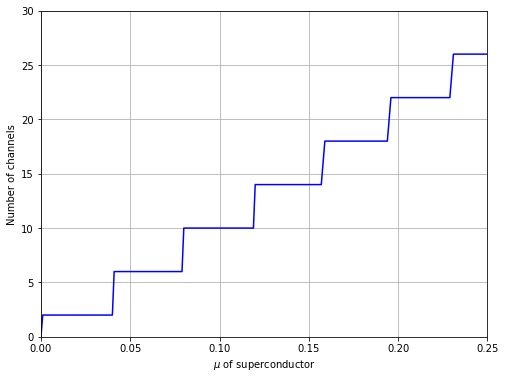

In [76]:
dimension = 401 # 50, 50, 401
max_value = 0.4 # 1, 0.04, 0.4

#channels = np.loadtxt(fname = f".\\Data\\mu_TI_to_S_{dimension}_{dimension}_{max_value}.txt")
channels = np.loadtxt(fname = f".\\Data\\mu_TI_to_S_{dimension}_{max_value}.txt")

mu_ti = np.linspace(0, max_value, dimension)
"""
mu_super = mu_ti

plt.pcolormesh(mu_ti,mu_super , channels, shading='nearest')
plt.colorbar()

plt.ylabel('$\mu$ of normal region')
plt.xlabel('$\mu$ of superconductor')
#plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{dimension}_{max_value}.pdf")
plt.savefig(fname =  f".\\Images\\mu_TI_to_S_{dimension}_{max_value}.pdf")

plt.show()
"""
plt.figure(figsize = (8,6))
plt.plot(mu_ti, channels,"b")
plt.xlabel('$\mu$ of superconductor')
plt.ylabel('Number of channels')
plt.grid()
plt.xlim(0, 0.25)
plt.ylim(0, 30)
plt.show()

### Check Scattering Matrix

#### Without TRS

In [42]:
mu = 0.042
params_TI['mu_bulk'] = mu
params_TI['mu_lead1'] = mu
params_TI['mu_lead2'] = mu
result = energy_operator_mask(systf1, params_TI, ph_sym=False, phases=np.zeros(nleads))
smat_e = pd.DataFrame(result[0])
smat_h = pd.DataFrame(result[1])
print(smat_e)
print(smat_h)

            0           1           2           3           4           5
0 -0.00+0.00j -0.00+0.00j -0.00+0.00j -0.99+0.14j  0.00+0.00j -0.00+0.00j
1 -0.00+0.00j  0.00-0.00j  0.00-0.00j -0.00+0.00j  0.58-0.81j  0.00+0.00j
2 -0.00-0.00j  0.00+0.00j  0.00+0.00j  0.00+0.00j -0.00+0.00j  0.98+0.17j
3 -0.73+0.69j -0.00-0.00j  0.00+0.00j  0.00-0.00j -0.00+0.00j -0.00+0.00j
4  0.00-0.00j  0.59+0.81j -0.00+0.00j -0.00+0.00j  0.00-0.00j -0.00-0.00j
5  0.00+0.00j  0.00-0.00j  0.41-0.91j -0.00-0.00j  0.00+0.00j -0.00-0.00j
            0           1           2           3           4           5
0 -0.00-0.00j -0.00-0.00j -0.00-0.00j -0.99-0.14j  0.00-0.00j -0.00-0.00j
1 -0.00-0.00j  0.00+0.00j  0.00+0.00j -0.00-0.00j  0.58+0.81j  0.00-0.00j
2 -0.00+0.00j  0.00-0.00j  0.00-0.00j  0.00-0.00j -0.00-0.00j  0.98-0.17j
3 -0.73-0.69j -0.00+0.00j  0.00-0.00j  0.00-0.00j -0.00-0.00j -0.00-0.00j
4 -0.00+0.00j  0.59-0.81j -0.00-0.00j -0.00-0.00j  0.00+0.00j -0.00+0.00j
5  0.00-0.00j  0.00+0.00j  0.41+0.91j 

### Check Andreev Spectrum

#### Without TRS

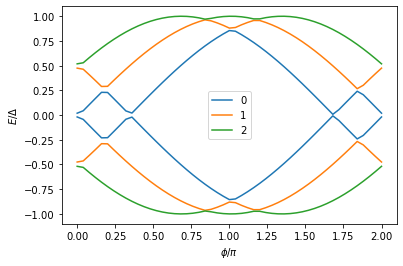

In [16]:
shifts = []
params_TI['mu_bulk'] = 0.042
params_TI['mu_lead1'] = 0.042
params_TI['mu_lead2'] = 0.042

fig, ax = plt.subplots()
ax.set_xlabel(r'$\phi/\pi$')
ax.set_ylabel(r'$E/\Delta$')

phases = np.linspace(0,2,51)
sol_list = []
for p in (phases)*np.pi:
    phase = [0, p]
    sol_list.append(energies_over_delta(systf1, params_TI, ph_sym=False, phases=phase, method='mask'))

sol_list = np.array(sol_list).T
sol_list2 = sol_list[::2]
i=0
for sol in sol_list2:
    ax.plot(phases, sol, 'C'+str(i), label=str(i))
    ax.plot(phases, -1*sol, 'C'+str(i))
    shifts.append(find_shift(phases, sol))
    i+=1
ax.legend()

# Appendix

## Band Structure

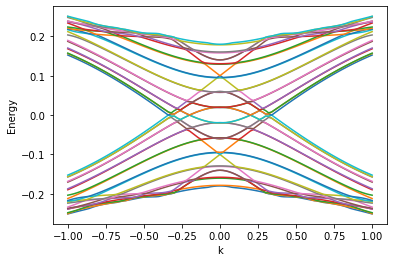

[[-0.25097233 -0.25057259 -0.24786069 ...  0.24786069  0.25057259
   0.25097233]
 [-0.248951   -0.24745831 -0.24572259 ...  0.24572259  0.24745831
   0.248951  ]
 [-0.24695896 -0.24441665 -0.24363547 ...  0.24363547  0.24441665
   0.24695896]
 ...
 [-0.24695896 -0.24441665 -0.24363547 ...  0.24363547  0.24441665
   0.24695896]
 [-0.248951   -0.24745831 -0.24572259 ...  0.24572259  0.24745831
   0.248951  ]
 [-0.25097233 -0.25057259 -0.24786069 ...  0.24786069  0.25057259
   0.25097233]]


In [50]:
def plot_bands(syst, momenta, return_bands=False, plot_bands=True, params=None, levels=0):
    bands = kwant.physics.Bands(syst.leads[0], params=params)
    energies = np.array([bands(k) for k in momenta])
    if levels!=0:
        mid = len(energies[0])//2
        a=energies[:,mid-levels:mid]
        b=energies[:,mid:mid+levels]
        energies = np.concatenate((a,b),axis=1)
    if plot_bands:
        fig, ax = plt.subplots()
        ax.set_xlabel('k')
        ax.set_ylabel('Energy')
        ax.plot(momenta, energies)
        #ax.plot(momenta, np.full(len(momenta), 0.005), 'b--')
        #ax.plot(momenta, np.full(len(momenta), 0.015), 'r--')
        plt.show()
    if return_bands:
        return energies
    

params_TI['mu_bulk'] = 0.01
params_TI['mu_lead1'] = 0.1
params_TI['mu_lead2'] = 0.1 
momenta = np.linspace(-1, 1, 101)
r1 = plot_bands(systf1, momenta, return_bands=True, levels=20, params=params_TI)

print(r1)